In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import pandas as pd
import gzip
import collections
import sys
sys.path.append('/usr/users/fsimone/tejaas')
from iotools import readgtf
from utils import cismasking

sys.path.append('../../')
import operator
import json
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/analysis/plots/tissue_table.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]

brain_tissues = ['bam','ban','bca','bceh','bce','bco','bfr','bhi','bhy','bnu','bpu','bsp','bsu']   
optim_tissues = ['haa', 'pan', 'spl', 'wb']


In [2]:
base_dir = "/cbscratch/franco/datasets"
gtffile = os.path.join(base_dir, "GENCODE/gencode.v26.annotation.gtf.gz")
genemapfile  = os.path.join(base_dir, "crossmappability/hg38_gene_mappability.txt.gz")
crossmapfile = os.path.join(base_dir, "crossmappability/hg38_cross_mappability_strength.txt.gz")

In [3]:
SNPINFO_FIELDS = ['chrom', 'varid', 'bp_pos', 'ref_allele', 'alt_allele', 'maf']
class SnpInfo(collections.namedtuple('_SnpInfo', SNPINFO_FIELDS)):
    __slots__ = ()

    
def Snp2info(snps_list):
    snpinfo = list()
    for snpid in snps_list:
        arr = snpid.split("_")
        chrom = int(arr[0][3:])
        pos = int(arr[1])
        this_snp = SnpInfo(chrom      = chrom,
                           bp_pos     = pos,
                           varid      = snpid,
                           ref_allele = "X",
                           alt_allele = "Y",
                           maf        = None)
        snpinfo.append(this_snp)
    return snpinfo

def knn_correction(expr, dosage, K, f=1):
    assert (expr.shape[0] == dosage.shape[1])
    pca = PCA(n_components=int(f * min(expr.shape[0], expr.shape[1]) ))
#     print("Original dimension: {:d} x {:d}".format(expr.shape[0], expr.shape[1]))
    pca.fit(expr) # requires N x G
    expr_pca = pca.transform(expr)
#     print("Reduced dimension: {:d} x {:d}".format(expr_pca.shape[0], expr_pca.shape[1]))

    def gene_distance(a, b):
        return np.linalg.norm(a - b)

    nsample = expr.shape[0]
    distance_matrix = np.zeros((nsample, nsample))
    for i in range(nsample):
        for j in range(i+1, nsample):
            dist = gene_distance(expr_pca[i,:], expr_pca[j,:])
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    kneighbor = K
    gx_knn = np.zeros_like(expr)
    gt_knn = np.zeros_like(dosage)
    neighbor_list = list()

    for i in range(nsample):
        neighbors = np.argsort(distance_matrix[i, :])[:kneighbor + 1][1:]
        gx_knn[i, :] = expr[i, :] - np.mean(expr[neighbors, :], axis = 0)
        # noisy_neighbors = np.random.choice(neighbors, size = int(2 * kneighbor / 3), replace = False)
        # noisy_neighbors = np.random.choice(neighbors, size = kneighbor, replace = True )
        noisy_neighbors = neighbors
        gt_knn[:, i] = dosage[:, i] - np.mean(dosage[:, noisy_neighbors], axis = 1)
        neighbor_list.append(neighbors)

    return gx_knn, gt_knn
    
def extend_cismask(genes, cismaskcomp, cross_gene_dict):
    # cross_gene_dict = read_crossmap(crossmapfile)
    genes_ix_dict = dict(zip([x.ensembl_id for x in genes], np.arange(len(genes))))
    crossmap_cismaskcomp = list()
    for cismask in cismaskcomp:
        gene_list = list()  # list of crossmapped genes for the cismask
        for gene in [genes[i] for i in cismask.rmv_id]:
            gene_list += cross_gene_dict[gene.ensembl_id]
        uniq_gene_list = list(set(gene_list))
        ugene_dict = collections.defaultdict(lambda: False) # significant speed-up by making a dict
        for g in uniq_gene_list:
            ugene_dict[g] = True
        cm_gene2rmv_ix = [genes_ix_dict[x.ensembl_id] for x in genes if ugene_dict[x.ensembl_id]]
        if len(cm_gene2rmv_ix) > 0:
            new_mask_genes = sorted(list(set(list(cismask.rmv_id) + cm_gene2rmv_ix)))
            new_cismask = cismask._replace(rmv_id = np.array(new_mask_genes))
            crossmap_cismaskcomp.append(new_cismask)
        else:
            crossmap_cismaskcomp.append(cismask)
    return crossmap_cismaskcomp

def read_tissue_genes(gx_file, geneinfo_dict):
    genes = list()
    with open(gx_file) as inst:
        next(inst)
        for line in inst:
            ensembl_id = line.split()[0]
            genes.append(geneinfo_dict[ensembl_id])
    return genes

def read_crossmap(crossmapfile):
    gene_pairs = collections.defaultdict(list)
    with gzip.open(crossmapfile, 'r') as instream:
        for line in instream:
            arr = line.rstrip().split()
            gene_pairs[arr[0].decode('utf-8')].append(arr[1].decode('utf-8'))
    return gene_pairs

cross_gene_dict = read_crossmap(crossmapfile) 

In [4]:
geneinfo = readgtf.gencode(gtffile, trim=False)

### reformat gene info
geneinfo_dict = dict()
for g in geneinfo:
    geneinfo_dict[g.ensembl_id] = g

In [5]:
import mpmath
mpmath.mp.dps = 50
def pvalue(x): return float(mpmath.log10(1 - 0.5 * (1 + mpmath.erf(x/mpmath.sqrt(2)))))

SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()
    
def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            chrom = int(arr[1])
            pos   = int(arr[2])
            maf   = float(arr[3])
            q     = float(arr[4])
            mu    = float(arr[5])
            sigma = float(arr[6])
            p     = float(arr[7])
            if sigma == 0:
                continue
            logp  = np.log10(p) if p != 0 else pvalue( (q - mu) / sigma)
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res

base_resdir = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/gtex_v8-aa/tejaas/permnull_sb0.1_knn30_crossmap/chr1/rr.txt"

target_file    = "trans_eqtls.txt.ld_prune"

## SHAPEIT 2 data
path_sb01    = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8/"
path_sb0006  = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma0006_knn30_cut5e-8/"
path_raw     = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/summary_5e-08/"


teqtls        = os.path.join(path_sb01, "{:s}/trans_eqtls_ldpruned.txt") 
teqtls_cm     = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.1_knn30_crossmap", target_file)
alt_teqtls    = os.path.join(path_sb0006, "{:s}/trans_eqtls_ldpruned.txt") 
alt_teqtls_cm = os.path.join(path_raw, "{:s}/tejaas", "permnull_sb0.006_knn30_crossmap", target_file)

teqtl_dict = collections.defaultdict(dict)
for ts in tshorts:
    if ts not in brain_tissues:
        if ts in optim_tissues:
            teqtl_dict["sb"][ts] = tejaas(alt_teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(alt_teqtls_cm.format(ts))
        else:
            teqtl_dict["sb"][ts] = tejaas(teqtls.format(ts))
            teqtl_dict["cm"][ts] = tejaas(teqtls_cm.format(ts))


In [6]:
import pandas as pd

# cm_allpval_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/all_variants_pvalues_tejaas_4optims_crossmap.txt"
# pval_df_cm = pd.read_csv(cm_allpval_file, header=0, index_col=0, sep="\t")

print("Loading all results")
allpval_file = "/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas_4optims.txt"
pval_df = pd.read_csv(allpval_file, header=0, index_col=0, sep="\t")

# ## Subset tissue dataframes of pvalues
# print(pval_df_cm.shape)
# print(pval_df.shape)

# tissues_set = [x for x in tshorts if x not in brain_tissues]
# pval_df_cm_subset = pval_df_cm[tissues_set]
# pval_df_subset = pval_df[tissues_set]

# print(pval_df_cm_subset.shape)
# print(pval_df_subset.shape)


### Load only the 4 optims tissues
# print("Loading all results")
# pval_file = "/cbscratch/franco/from_saikat/gtex_v8_202003/all_variants_pvalues_tejaas_only4optims.txt"
# pval_df   = pd.read_csv(pval_file, header=0, index_col=0, sep="\t")

print("Loading crossmap results - 4 optims")
cm0006_pval_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/all_variants_pvalues_tejaas_only4optims_crossmap_sb0006.txt"
pval_df_cm0006   = pd.read_csv(cm0006_pval_file, header=0, index_col=0, sep="\t")

# cm001_pval_file  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_022021/all_variants_pvalues_tejaas_only4optims_crossmap_sb001.txt"
# pval_df_cm001    = pd.read_csv(cm001_pval_file, header=0, index_col=0, sep="\t")

print("Loading crossmap results - 4 good tissues")
cm_pval_file     = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/all_variants_pvalues_tejaas_only4tissues_test_crossmap.txt"
pval_df_cm       = pd.read_csv(cm_pval_file, header=0, index_col=0, sep="\t")

Loading all results
Loading crossmap results - 4 optims
Loading crossmap results - 4 good tissues


In [7]:
pval_df_cm.head()

,as,aa,ms,sse
tissues,,,,
chr10_100000235_C_T_b38,0.334391,0.118680,0.531391,0.964654
chr10_100000943_G_A_b38,0.119109,0.179888,0.858760,0.077776
chr10_100000979_T_C_b38,0.106356,0.104938,0.898848,0.312808
chr10_100002012_T_C_b38,0.392354,0.169437,0.618659,0.057971
chr10_100002038_G_A_b38,0.587871,NaN,0.111461,NaN


## Write maskes expression files for a few tissues
### Uses only the first mask or some defined mask

In [8]:
global_cutoff = -np.log10(5e-8)

# for ts in optim_tissues:
for ts in ["as", "ms", "sse", "aa"]+optim_tissues:
    print(f"Tissue: {ts}")

    # gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_knn30_norm.txt.protein_coding_lncRNA_filtered"
    df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

    snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
    snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]

    both_sets = list(set(snpids + snpids_cm))  

    logpvals    = pval_df_subset[ts][both_sets]
    logpvals_cm = pval_df_cm_subset[ts][both_sets]

    # Find snps that become significant after crossmap filter
    sig_after_cm_ix      = logpvals < global_cutoff
    snpinfo_tissue       = Snp2info(both_sets)
    snpinfo_sig_after_cm = [snp for i, snp in enumerate(snpinfo_tissue) if sig_after_cm_ix[i]]

    print(f"SNPs before cm: {len(snpids)}")
    print(f"SNPs after cm:  {len(snpids_cm)}")
    print(f"SNPs brought in {np.sum(sig_after_cm_ix)}")

    ts_genes = read_tissue_genes(gx_file, geneinfo_dict)

    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo_sig_after_cm, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)
    
    mask_i = 10
            
    if len(crossmap_cismaskcomp) < mask_i:
        mask_i = len(crossmap_cismaskcomp)
    print(f"masked crossmap-genes: {len(crossmap_cismaskcomp[mask_i].rmv_id)}")
    print(f"masked cis-genes: {len(cismaskcomp[mask_i].rmv_id)}")

    usegenes_cm = np.ones(df.shape[0], dtype=bool)
    thismask_cm = crossmap_cismaskcomp[mask_i]
    if thismask_cm.rmv_id.shape[0] > 0: usegenes_cm[thismask_cm.rmv_id] = False      
    df_cm = df[usegenes_cm]

    usegenes = np.ones(df.shape[0], dtype=bool)
    thismask = cismaskcomp[mask_i]
    if thismask.rmv_id.shape[0] > 0: usegenes[thismask.rmv_id] = False   
    df_cis = df[usegenes]

    ## Write down these expressions to find out if there are differences in the sigma beta optimization
    df_cm.to_csv(f"{ts}_knn30_crossmap_filtered_{mask_i}.txt", sep="\t", header=True, index=True)
    df_cis.to_csv(f"{ts}_knn30_cismask_filtered_{mask_i}.txt", sep="\t", header=True, index=True)

Tissue: as
SNPs before cm: 586
SNPs after cm:  383
SNPs brought in 15
masked crossmap-genes: 5981
masked cis-genes: 7
Tissue: ms
SNPs before cm: 2253
SNPs after cm:  1645
SNPs brought in 39
masked crossmap-genes: 6371
masked cis-genes: 31
Tissue: sse
SNPs before cm: 400
SNPs after cm:  296
SNPs brought in 26
masked crossmap-genes: 7415
masked cis-genes: 17
Tissue: aa
SNPs before cm: 1298
SNPs after cm:  908
SNPs brought in 22
masked crossmap-genes: 6386
masked cis-genes: 7
Tissue: haa
SNPs before cm: 64
SNPs after cm:  236
SNPs brought in 173
masked crossmap-genes: 6985
masked cis-genes: 43
Tissue: pan
SNPs before cm: 179
SNPs after cm:  356
SNPs brought in 178
masked crossmap-genes: 5738
masked cis-genes: 6
Tissue: spl
SNPs before cm: 1354
SNPs after cm:  1666
SNPs brought in 371
masked crossmap-genes: 7608
masked cis-genes: 40
Tissue: wb
SNPs before cm: 6269
SNPs after cm:  11482
SNPs brought in 5264
masked crossmap-genes: 5706
masked cis-genes: 25


In [294]:
## Copy original expressions to facilitate calculations
import shutil

for ts in optim_tissues:
# for ts in ["as", "ms", "sse", "aa"]+optim_tissues:
    print(f"Tissue: {ts}")

    # gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    # dest_file = f"{ts}_tpms_qcfilter.txt"
    gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_knn30_norm.txt.protein_coding_lncRNA_filtered"
    dest_file = f"{ts}_knn30_norm.txt"
    shutil.copy(gx_file, dest_file)

Tissue: haa
Tissue: pan
Tissue: spl
Tissue: wb


## Separate cismasks of brought in and filtered out SNPs

In [10]:
global_cutoff = -np.log10(5e-8)

# for ts in optim_tissues:
tissue_masks = dict()
for ts in ["as", "ms", "sse", "aa"]+optim_tissues:
    print(f"Tissue: {ts}")

    # gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_knn30_norm.txt.protein_coding_lncRNA_filtered"
    df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

    snpids    = [x.rsid for x in teqtl_dict["sb"][ts]]
    snpids_cm = [x.rsid for x in teqtl_dict["cm"][ts]]

    both_sets      = list(set(snpids + snpids_cm))  
    snpinfo_tissue = Snp2info(both_sets)
    
    logpvals = pval_df[ts][both_sets]
    if ts in optim_tissues: 
        logpvals_cm = pval_df_cm0006[ts][both_sets]
    else:
        logpvals_cm = pval_df_cm[ts][both_sets]

    # Find snps that become significant after crossmap filter
    sig_after_cm_ix      = logpvals < global_cutoff
    snpinfo_sig_after_cm = [snp for i, snp in enumerate(snpinfo_tissue) if sig_after_cm_ix[i]]

    print(f"SNPs before cm: {len(snpids)}")
    print(f"SNPs after cm:  {len(snpids_cm)}")
    print(f"SNPs brought in   {np.sum(sig_after_cm_ix)}")
    print(f"SNPs filtered out {np.sum(logpvals_cm < global_cutoff)}")

    ts_genes = read_tissue_genes(gx_file, geneinfo_dict)

    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo_tissue, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

    masks_bi = list()
    masks_fo = list()
    for mask_i in range(len(crossmap_cismaskcomp)):
        targ_snp    = both_sets[cismaskcomp[mask_i].apply2[0]]
        snp_logp    = pval_df[ts][targ_snp]
        if ts in optim_tissues:
            snp_logp_cm = pval_df_cm0006[ts][targ_snp]
        else:
            snp_logp_cm = pval_df_cm[ts][targ_snp]

        if snp_logp >= global_cutoff and snp_logp_cm < global_cutoff: # filtered out
            masks_fo.append(crossmap_cismaskcomp[mask_i])
        if snp_logp < global_cutoff and snp_logp_cm >= global_cutoff: # brought in
            masks_bi.append(crossmap_cismaskcomp[mask_i])
    print(f"brough in masks: {len(masks_bi)}")
    print(f"filtered out masks: {len(masks_fo)}")
        
    tissue_masks[ts] = dict()
    tissue_masks[ts]["bi"] = masks_bi
    tissue_masks[ts]["fo"] = masks_fo
    

Tissue: as
SNPs before cm: 586
SNPs after cm:  383
SNPs brought in   15
SNPs filtered out 219
brough in masks: 15
filtered out masks: 219
Tissue: ms
SNPs before cm: 2253
SNPs after cm:  1645
SNPs brought in   39
SNPs filtered out 655
brough in masks: 39
filtered out masks: 654
Tissue: sse
SNPs before cm: 400
SNPs after cm:  296
SNPs brought in   26
SNPs filtered out 132
brough in masks: 26
filtered out masks: 132
Tissue: aa
SNPs before cm: 1298
SNPs after cm:  908
SNPs brought in   22
SNPs filtered out 412
brough in masks: 22
filtered out masks: 412
Tissue: haa
SNPs before cm: 64
SNPs after cm:  236
SNPs brought in   173
SNPs filtered out 1
brough in masks: 173
filtered out masks: 1
Tissue: pan
SNPs before cm: 179
SNPs after cm:  356
SNPs brought in   178
SNPs filtered out 1
brough in masks: 178
filtered out masks: 1
Tissue: spl
SNPs before cm: 1354
SNPs after cm:  1666
SNPs brought in   371
SNPs filtered out 58
brough in masks: 371
filtered out masks: 58
Tissue: wb
SNPs before cm: 626

In [360]:
ts = "spl"
gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_knn30_norm.txt.protein_coding_lncRNA_filtered"
df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

mask_bi = tissue_masks[ts]["bi"][0]
mask_fo = tissue_masks[ts]["fo"][0]

usegenes_bi = np.ones(df.shape[0], dtype=bool)
print(f"mask bi: {mask_bi.rmv_id.shape}")
if mask_bi.rmv_id.shape[0] > 0: usegenes_bi[mask_bi.rmv_id] = False      
df_cm_bi = df[usegenes_bi]

usegenes_fo = np.ones(df.shape[0], dtype=bool)
print(f"mask fo: {mask_fo.rmv_id.shape}")
if mask_fo.rmv_id.shape[0] > 0: usegenes_fo[mask_fo.rmv_id] = False   
df_cm_fo = df[usegenes_fo]

mask bi: (5587,)
mask fo: (6845,)


In [361]:
df.shape

(16395, 227)

In [362]:
U, S, Vt    = np.linalg.svd(df.values.T, full_matrices=False)
U, S_bi, Vt = np.linalg.svd(df_cm_bi.values.T, full_matrices=False)
U, S_fo, Vt = np.linalg.svd(df_cm_fo.values.T, full_matrices=False)

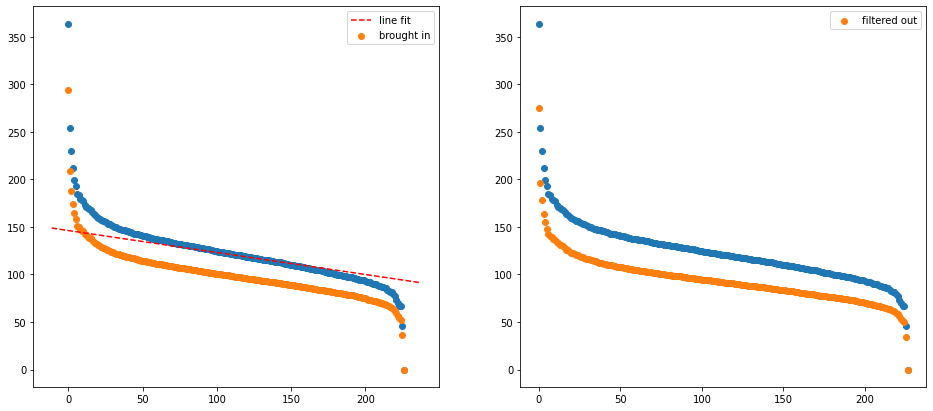

In [363]:
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(np.arange(len(S)), S)
ax1.scatter(np.arange(len(S)), S_bi, label="brought in")

b, y0 = fit_line(S)
abline(ax1, b, y0)

ax2.scatter(np.arange(len(S)), S)
ax2.scatter(np.arange(len(S)), S_fo, label="filtered out")

ax1.legend()
ax2.legend()
plt.savefig(f"{ts}_singular_values_crossmaps.png")
plt.show()

spl


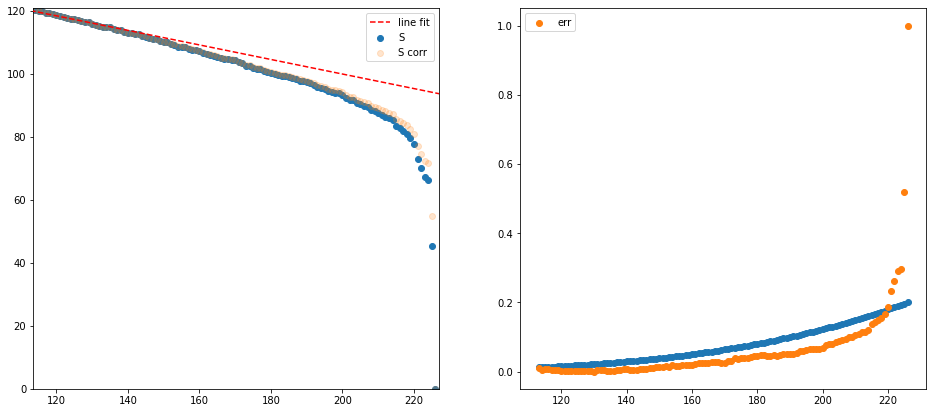

In [364]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

def fit_line(S):
    rank = len(S)
    start= int(rank*55/100)
    end  = int(rank*55/100+3)
    x    = np.arange(rank)[start:end].reshape(-1, 1)
    y    = S[start:end].reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    b  = reg.coef_[0]
    y0 = reg.intercept_
    return b, y0

def func(x, a, b):
    return a * x**4 + b

def correct_S(S):
    rank = len(S)
    x_vals = np.arange(rank/2, rank)
    b, y0 = fit_line(S)
    y_vals = y0 + b * x_vals
    err  = np.abs(y_vals - S[int(rank/2): rank])
    popt, pcov = curve_fit(func, x_vals, err/np.max(err), bounds=(0,[1,1]))
    corr = np.zeros(len(S))
    corr[:int(rank/2)] = S[:int(rank/2)]
    corr[int(rank/2):] = S[int(rank/2): rank] + err*func(x_vals, *popt)
    corr[-1] = S[-1]
    return corr, popt, err

def abline(ax, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', zorder=10, color="red", label="line fit")

print(ts)
rank = len(S)
fig = plt.figure(figsize=(16,7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(np.arange(len(S)), S, label="S")

b, y0 = fit_line(S)
abline(ax1, b, y0)
corrS, popt, err = correct_S(S)
ax1.scatter(np.arange(len(S)), corrS, label="S corr", alpha=0.2)

x_vals = np.arange(int(rank/2), rank)
ax2.scatter(x_vals, func(x_vals, *popt))
ax2.scatter(x_vals, err/np.max(err), label="err")

ax1.legend()
ax2.legend()
ax1.set_xlim(rank/2, rank)
ax1.set_ylim(0, S[int(rank/2)])
# plt.savefig(f"{ts}_singular_values_corrected.png")
plt.show()

In [374]:
a = np.arange(0,100)
b = np.repeat(1, 100)

a[-31:-1] = np.repeat(2,30)
a[-1] = 0
a


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  0])

spl


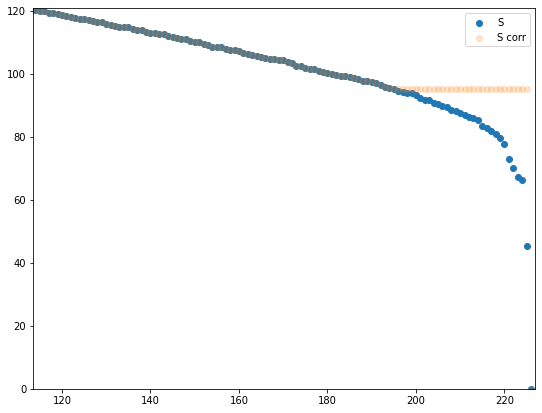

In [375]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression

def fit_line(S):
    rank = len(S)
    start= int(rank*55/100)
    end  = int(rank*55/100+3)
    x    = np.arange(rank)[start:end].reshape(-1, 1)
    y    = S[start:end].reshape(-1, 1)
    reg = LinearRegression().fit(x, y)
    b  = reg.coef_[0]
    y0 = reg.intercept_
    return b, y0

def func(x, a, b):
    return a * x**4 + b

def correct_S30(S):
    rank = len(S)
    corr = np.zeros(len(S))
    if rank > 32:
        corr[:-31] = S[:-31]
        corr[-31:-1] = np.repeat(S[-32], 30)
    corr[-1] = S[-1]
    return corr


print(ts)
rank = len(S)
fig = plt.figure(figsize=(9,7))
ax1 = fig.add_subplot(111)


ax1.scatter(np.arange(len(S)), S, label="S")
corrS = correct_S30(S)
ax1.scatter(np.arange(len(S)), corrS, label="S corr", alpha=0.2)

ax1.legend()
ax1.set_xlim(rank/2, rank)
ax1.set_ylim(0, S[int(rank/2)])
# plt.savefig(f"{ts}_singular_values_corrected.png")
plt.show()

spl


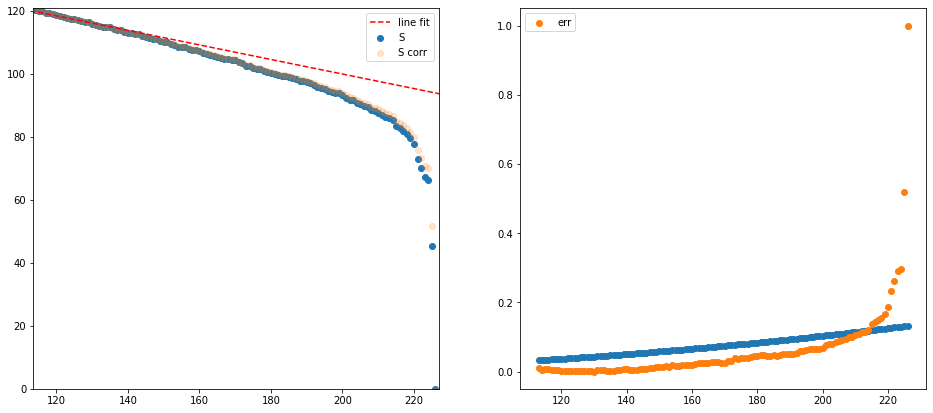

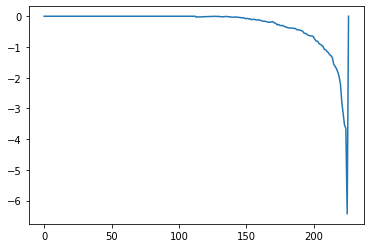

In [343]:
for ts in ["spl"]: #["as", "ms", "sse", "aa"]+optim_tissues:
    gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_knn30_norm.txt.protein_coding_lncRNA_filtered"
    df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

    U, S, Vt    = np.linalg.svd(df.values.T, full_matrices=False)

    print(ts)
    rank = len(S)
    fig = plt.figure(figsize=(16,7))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.scatter(np.arange(len(S)), S, label="S")

    b, y0 = fit_line(S)
    abline(ax1, b, y0)
    corrS, popt, err = correct_S(S)
    ax1.scatter(np.arange(len(S)), corrS, label="S corr", alpha=0.2)

    x_vals = np.arange(int(rank/2), rank)
    ax2.scatter(x_vals, func(x_vals, *popt))
    ax2.scatter(x_vals, err/np.max(err), label="err")

    ax1.legend()
    ax2.legend()
    ax1.set_xlim(rank/2, rank)
    ax1.set_ylim(0, S[int(rank/2)])
    plt.savefig(f"{ts}_singular_values_corrected.png")
    plt.show()
    
    plt.plot(S - corrS)
    plt.show()
    

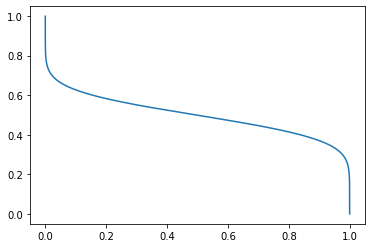

In [113]:
import scipy
from scipy.optimize import curve_fit

test = scipy.stats.norm.cdf(np.arange(rank)/rank, loc=0.5, scale=.1)
plt.plot(test[::-1], np.arange(rank)/rank)
plt.show()
   

# Avg number of masked genes for cis and crossmap

In [7]:
############# used to test a single tissue with random ld-pruned SNPs

snp_file = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2/raw/gtex_v8-wb/tejaas/permnull_sb0.006_knn30_crossmap/snps_list.txt"
snp_list = list()
nsubset  = 1000
with open(snp_file) as inst:
    next(inst)
    for line in inst:
        snp_list.append(line.split("\t")[0])

sampled_snps = list(np.random.choice((snp_list), size = nsubset, replace = False))
print(len(sampled_snps))
snpinfo = Snp2info(sampled_snps)

for ts in ["wb"]:
    print(f"Tissue: {ts}")

    # gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_tpms_qcfilter.txt.protein_coding_lncRNA_filtered"
    gx_file = f"/cbscratch/franco/trans-eqtl/new_preprocess_feb2020_freeze/gtex_v8/expression/tpms/{ts}_knn30_norm.txt.protein_coding_lncRNA_filtered"
    df = pd.read_csv(gx_file, header=0, index_col=0, sep="\t")

    ts_genes = read_tissue_genes(gx_file, geneinfo_dict)

    #### Obtain cismasks and add crossmappable genes
    cismasklist = cismasking.get_cismasklist(snpinfo, ts_genes, None, window=1e6)
    cismaskcomp = cismasking.compress_cismasklist(cismasklist)
    crossmap_cismaskcomp = extend_cismask(ts_genes, cismaskcomp, cross_gene_dict)

1000
Tissue: wb


In [23]:
cm_masksizes  = np.array([len(x.rmv_id) for x in crossmap_cismaskcomp])
cis_masksizes = np.array([len(x.rmv_id) for x in cismaskcomp])
avg_masksize_cm  = np.mean(cm_masksizes)
avg_masksize_cis = np.mean(cis_masksizes)
print(f"Avg crossmap masksize: {avg_masksize_cm}")
print(f"Avg cis masksize: {avg_masksize_cis}")

Avg crossmap masksize: 3508.092914506455
Avg cis masksize: 9.019823116803904


In [8]:
cismasklist[:10]

[array([2427, 2428, 2429]),
 array([4986, 4987, 4988, 4989, 4990, 4991, 4992, 4993, 4994, 4995, 4996]),
 array([8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801]),
 array([2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939, 2940]),
 array([5081, 5082, 5083, 5084]),
 array([1747, 1748, 1749, 1750, 1751, 1752]),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([9396, 9397, 9398, 9399, 9400, 9401, 9402])]